In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

df = pd.read_csv('./desafio_indicium_imdb.csv')

Comecei analisando o dataframe:

In [30]:
print(df.head())
print(df.describe())
print(df.info())
print(df.isnull().sum())

   Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
1  W

Aqui, noto algumas coisas que podem atrapalhar a análise. A primeira, é que existe uma coluna extra com o índice dos filmes, que acaba poluindo a matriz de correlação.

In [31]:
df.drop(columns=['Unnamed: 0'], inplace=True)

Outra coisa é que "Gross", a coluna que condiz com o faturamento do filme, é um objeto, e não um número. É plausível pensar que o faturamento de um filme pode ter uma correlação com a sua nota, por isso, decidi convertê-lo em número para poder analisar a correlação mais tarde.

In [32]:
df['Gross'] = df['Gross'].str.replace(',', '').str.strip()
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')

Outra coisa que noto, é que, similarmente, o ano de lançamento e a duração do filme são objetos, e não inteiros. Isso pode fazer sentido, já que geralmente não realizamos operações numéricas com essas colunas, mas uma das minhas teorias é a de que filmes mais antigos tendem a ter uma nota maior. Por isso, é importante para mim que essas colunas sejam numéricas.

In [33]:
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')
df['Runtime'] = df['Runtime'].str.replace('min', '').str.strip()
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')

Em seguida, o que chama mais atenção é o fato de que algumas células estão vazias. Mais especificamente, 101 células na coluna "Certificate", 157 em "Meta_score" e 169 em "Gross".

In [34]:
# Abordagem 1: Preencher com a média
#df['Gross'].fillna(df['Gross'].mean(), inplace=True)

# Abordagem 2: Dropar as linhas
# df.dropna(subset=['Gross'], inplace=True)

#Abordagem 3: Preencher com a mediana
df['Gross'].fillna(df['Gross'].median(), inplace=True)

C:\Users\guilh\AppData\Local\Temp\ipykernel_23904\1763490309.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Gross'].fillna(df['Gross'].median(), inplace=True)


Uma das minhas hipóteses é a de que filmes com diretores famosos e renomados tendem a receber uma nota maior no IMDB. Para testar isso, observo a média da nota IMDB de acordo com a quantidade de filmes que os diretores possuem nessa lista.

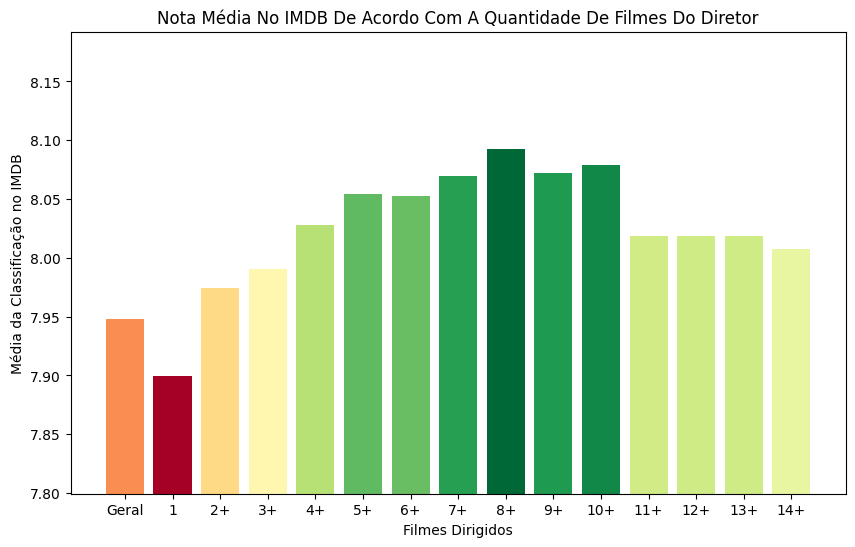

In [35]:
director_ratings = df.groupby('Director')['IMDB_Rating'].mean().reset_index()
director_ratings = director_ratings.sort_values(by='IMDB_Rating', ascending=False)

director_count = df['Director'].value_counts()

# Média do Dataframe
average_ratings = [df['IMDB_Rating'].mean()]
labels = ['Geral']

# Média dos diretores com apenas 1 filme
directors_filter = director_count[director_count == 1 ].index.tolist()
filtered_df = df[df['Director'].isin(directors_filter)]
average_ratings.append(filtered_df["IMDB_Rating"].mean())
labels.append('1')

# Média dos diretores com 2+ filmes
for i in range(2, 15):
    directors_filter = director_count[director_count >= i].index.tolist()
    filtered_df = df[df['Director'].isin(directors_filter)]
    average_ratings.append(filtered_df['IMDB_Rating'].mean())
    labels.append(f'{i}+')


norm = mcolors.Normalize(vmin=min(average_ratings), vmax=max(average_ratings))
colors = [plt.cm.RdYlGn(norm(rating)) for rating in average_ratings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, average_ratings, color=colors)
plt.xlabel('Filmes Dirigidos')
plt.ylabel('Média da Classificação no IMDB')
plt.title('Nota Média No IMDB De Acordo Com A Quantidade De Filmes Do Diretor')
plt.ylim(min(average_ratings) - 0.1, max(average_ratings) + 0.1)

    
plt.show()

Como podemos ver, os dados sugerem que, embora a relação entre quantidade de filmes dirigidos e média da classificação IMDB não seja estritamente proporcional, há uma tendência de que diretores mais experientes geralmente alcancem uma média de IMDB mais alta do que diretores iniciantes. Portanto, é razoável hipotetizar que filmes dirigidos por diretores com 3+ filmes têm uma probabilidade maior de receber notas melhores no IMDB do que filmes de diretores novatos.

Como o resultado me interessou, decidi conferir se o mesmo era verdade para o Meta_score também.

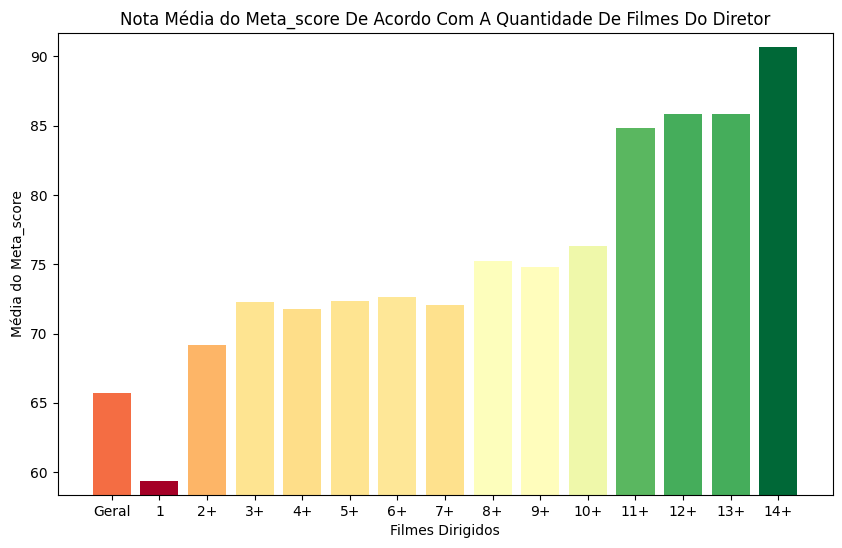

In [64]:
temp_df = df.dropna(subset=['Meta_score'])
director_ratings = temp_df.groupby('Director')['Meta_score'].mean().reset_index()
director_ratings = director_ratings.sort_values(by='Meta_score', ascending=False)

director_count = temp_df['Director'].value_counts()

# Média do Dataframe
average_ratings = [temp_df['Meta_score'].mean()]
labels = ['Geral']

# Média dos diretores com apenas 1 filme
directors_filter = director_count[director_count == 1].index.tolist()
filtered_df = temp_df[temp_df['Director'].isin(directors_filter)]
average_ratings.append(filtered_df["Meta_score"].mean())
labels.append('1')

# Média dos diretores com 2+ filmes
for i in range(2, 15):
    directors_filter = director_count[director_count >= i].index.tolist()
    filtered_df = temp_df[temp_df['Director'].isin(directors_filter)]
    average_ratings.append(filtered_df['Meta_score'].mean())
    labels.append(f'{i}+')

norm = mcolors.Normalize(vmin=min(average_ratings), vmax=max(average_ratings))
colors = [plt.cm.RdYlGn(norm(rating)) for rating in average_ratings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, average_ratings, color=colors)
plt.xlabel('Filmes Dirigidos')
plt.ylabel('Média do Meta_score')
plt.title('Nota Média do Meta_score De Acordo Com A Quantidade De Filmes Do Diretor')
plt.ylim(min(average_ratings) - 1, max(average_ratings) + 1)

plt.show()


O resultado dessa vez foi surpreendente. É possível ver que o crescimento do Meta Score de acordo com a quantidade de filmes de um diretor é consideravelmente mais acentuado do que o do IMDB Rating.

Levando o resultado dessas análises em consideração, decidi que valia a pena adicionar uma coluna no dataframe que levasse em consideração a experiência do diretor de cada filme, contasse quantos filmes aquele diretor havia feito, pois seria uma variável relevante na matriz de correlação. Além disso, optei por uma outra abordagem alternativa: Adicionar também ma coluna binária que diz se um diretor participou de 3 ou mais filmes.

In [65]:
df['No_of_Directed_Movies'] = df['Director'].map(df['Director'].value_counts())
df['Experienced_Director'] = (df['No_of_Directed_Movies'] >= 3).astype(int)

Em seguida, achei interessante fazer a mesma análise para os atores. Isto é, verificar se atores famosos também influenciavam na classificação de um filme. Para isso, decidi começar checando se haviam erros a serem tratados. Primeiro, decidi checar se um ator pode aparecer múltiplas vezes na mesma linha. Depois, chequei se um ator pode aparecer em colunas diferentes, por exemplo, se ele pode aparecer como Star1 em um filme e Star2 em outro.

In [38]:
# Criando um DataFrame separado para os testes
actor_df = pd.DataFrame(df)

# Checando se o Star1 aparece repetidas vezes na mesma linha
same_line_mask = actor_df.apply(lambda row: row['Star1'] in (row['Star2'], row['Star3'], row['Star4']), axis=1)
print(len(actor_df[same_line_mask]))



# Checando se o Star1 aparece em colunas diferentes em outros filmes
other_columns = pd.concat([df['Star2'], df['Star3'], df['Star4']])
actor_df['Star1_duplicate'] = actor_df['Star1'].apply(lambda x: x in other_columns.values)

print(len(actor_df[actor_df['Star1_duplicate']]))

4
508


Após perceber que haviam alguns pontos a serem corrigidos, decidi tratar essas colunas, separar a quantidade de filmes que cada ator havia feito, e realizar a mesma análise em relação ao IMDB Rating e Meta_score.

Comecei criando um novo dataframe, com uma coluna para a contagem de quantos filmes cada ator participou. Tomei os cuidados de considerar o mesmo ator em colunas diferentes e de não contar um ator mais de uma vez na mesma linha.

Em seguida, usei o dataframe original para calcular a média do IMDB em que cada ator participou e calculei a média das classificações de acordo com o número de filmes dos atores.

Finalmente, repeti os mesmos passos para o Meta_score, porém com o cuidado extra de dropar as linhas em que o Meta_score não aparecia.

C:\Users\guilh\AppData\Local\Temp\ipykernel_23904\3858176159.py:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['Star'] = df[['Star1', 'Star2', 'Star3', 'Star4']].apply(lambda x: pd.unique(x.dropna().tolist()), axis=1)


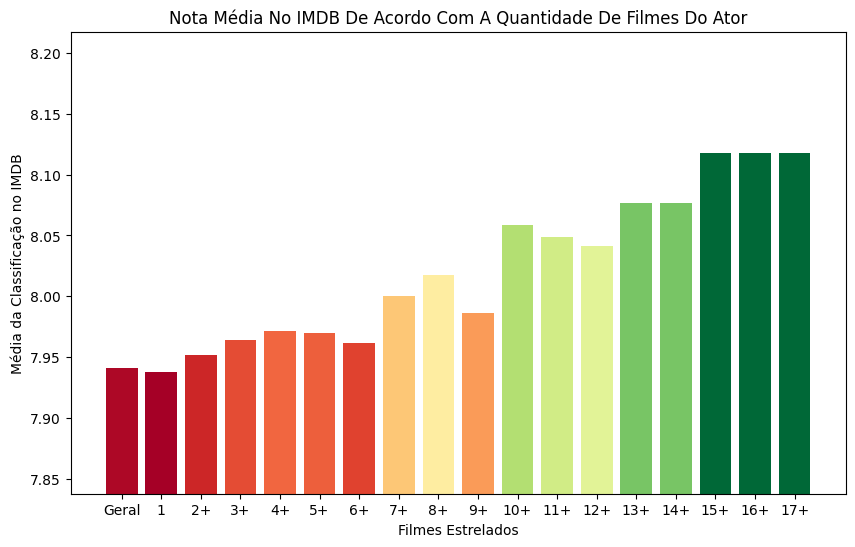

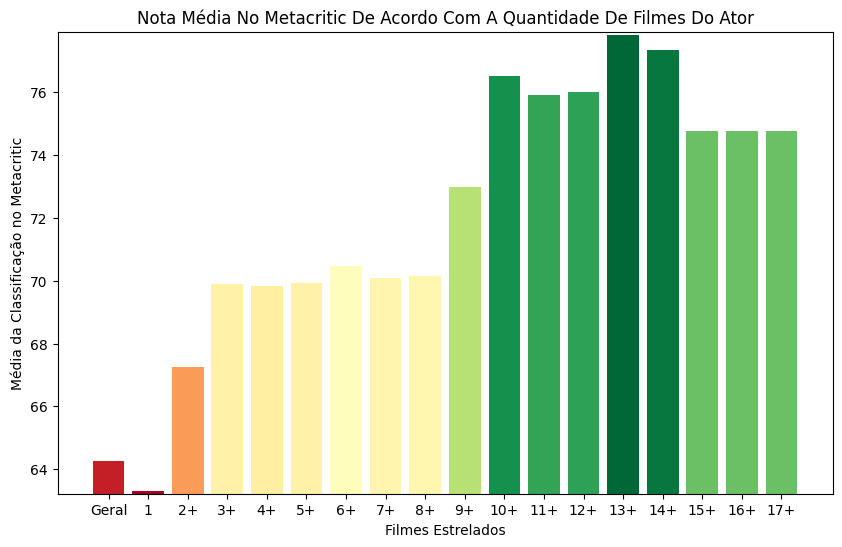

In [63]:
all_stars = pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']])

# Certificando que um ator não aparecerá duplicado na mesma linha
actors_per_movie = df[['Star1', 'Star2', 'Star3', 'Star4']].apply(lambda row: set(row), axis=1)

# Certificando que os atores são contados independentemente da coluna em que apareçam 
all_stars_unique = pd.Series([actor for actors in actors_per_movie for actor in actors])
star_counts = all_stars_unique.value_counts()

star_df = pd.DataFrame({
    'Star': star_counts.index,
    'No_of_Movies': star_counts.values
})

# Capturando o IMDB médio de cada ator
df['Star'] = df[['Star1', 'Star2', 'Star3', 'Star4']].apply(lambda x: pd.unique(x.dropna().tolist()), axis=1)
exploded_df = df.explode('Star')
imdb_ratings = exploded_df.groupby('Star')['IMDB_Rating'].mean().reset_index()

star_df = pd.merge(star_df, imdb_ratings, on='Star')
star_df.rename(columns={'IMDB_Rating': 'Average_IMDB_Rating'}, inplace=True)

# Plotando
# Média do Dataframe
average_ratings = [star_df['Average_IMDB_Rating'].mean()]
labels = ['Geral']

# Média dos atores com apenas 1 filme
average_ratings.append(star_df[star_df['No_of_Movies'] == 1]['Average_IMDB_Rating'].mean())
labels.append('1')

# Média dos atores com 2+ filmes
for i in range(2, 18):
    average_ratings.append(star_df[star_df['No_of_Movies'] >= i]['Average_IMDB_Rating'].mean())
    labels.append(f'{i}+')

norm = mcolors.Normalize(vmin=min(average_ratings), vmax=max(average_ratings))
colors = [plt.cm.RdYlGn(norm(rating)) for rating in average_ratings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, average_ratings, color=colors)
plt.xlabel('Filmes Estrelados')
plt.ylabel('Média da Classificação no IMDB')
plt.title('Nota Média No IMDB De Acordo Com A Quantidade De Filmes Do Ator')
plt.ylim(min(average_ratings) - 0.1, max(average_ratings) + 0.1)

    
plt.show()

# Capturando o Meta médio de cada ator
exploded_df = exploded_df.dropna(subset=['Meta_score'])
meta_ratings = exploded_df.groupby('Star')['Meta_score'].mean().reset_index()

star_df = pd.merge(star_df, meta_ratings, on='Star')
star_df.rename(columns={'Meta_score': 'Average_Meta_score'}, inplace=True)

# Plotando
# Média do Dataframe
average_ratings = [star_df['Average_Meta_score'].mean()]
labels = ['Geral']

# Média dos atores com apenas 1 filme
average_ratings.append(star_df[star_df['No_of_Movies'] == 1]['Average_Meta_score'].mean())
labels.append('1')

# Média dos atores com 2+ filmes
for i in range(2, 18):
    average_ratings.append(star_df[star_df['No_of_Movies'] >= i]['Average_Meta_score'].mean())
    labels.append(f'{i}+')

norm = mcolors.Normalize(vmin=min(average_ratings), vmax=max(average_ratings))
colors = [plt.cm.RdYlGn(norm(rating)) for rating in average_ratings]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, average_ratings, color=colors)
plt.xlabel('Filmes Estrelados')
plt.ylabel('Média da Classificação no Metacritic')
plt.title('Nota Média No Metacritic De Acordo Com A Quantidade De Filmes Do Ator')
plt.ylim(min(average_ratings) - 0.1, max(average_ratings) + 0.1)

    
plt.show()

A análise acima implica que filmes com atores conhecidos costumam ir melhor tanto com o público quanto com a crítica, e por isso, achei interessante levar esse número em consideração na matriz de correlação. 

Como existem 4 colunas com atores no dataframe, pensei em uma maneira criativa de responder as seguintes perguntas: 

1 - O quão famosos são os atores estrelando o filme como um todo?

Para responder essa, decidi por utilizar uma média simples da quantidade de filmes estrelados de todos os atores de cada filme.

2 - Algum ator muito famoso estrelou o filme?

Para responder essa, criei uma coluna que tem o valor 1, caso qualquer ator no filme tenha estreado em 5 ou mais filmes.

In [ ]:
def average_fame(row):
    stars = [row['Star1'], row['Star2'], row['Star3'], row['Star4']]
    
    # Obtém o número de filmes estrelados por cada ator a partir de star_df
    fame_counts = star_df.set_index('Star').loc[stars, 'No_of_Movies']
    
    # Calcula a média de filmes estrelados
    average_fame = fame_counts.sum() / 4 if len(stars) > 0 else 0
    return average_fame

df['Stars_Fame'] = df.apply(average_fame, axis=1)


df['No_of_Directed_Movies'] = df['Director'].map(df['Director'].value_counts())
df['Experienced_Director'] = (df['No_of_Directed_Movies'] >= 3).astype(int)

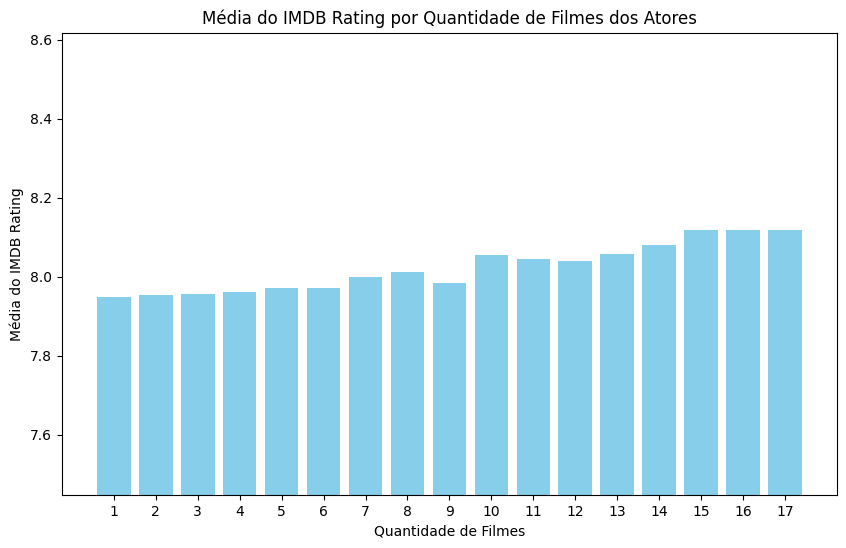

    No_of_Movies  Average_IMDB_Rating
0              1             7.947948
1              2             7.953929
2              3             7.955506
3              4             7.961959
4              5             7.970101
5              6             7.970118
6              7             8.000433
7              8             8.011111
8              9             7.984932
9             10             8.055000
10            11             8.045556
11            12             8.039062
12            13             8.058537
13            14             8.080645
14            15             8.117647
15            16             8.117647
16            17             8.117647


In [43]:

# Supondo que o DataFrame 'df' e 'star_df' já existam

# Mapear a quantidade de filmes de cada ator para o DataFrame 'df'
df['Star1_Count'] = df['Star1'].map(star_df.set_index('Star')['No_of_Movies'])
df['Star2_Count'] = df['Star2'].map(star_df.set_index('Star')['No_of_Movies'])
df['Star3_Count'] = df['Star3'].map(star_df.set_index('Star')['No_of_Movies'])
df['Star4_Count'] = df['Star4'].map(star_df.set_index('Star')['No_of_Movies'])

# Preencher valores NaN com 0 (caso algum ator não esteja no star_df)
df.fillna(0, inplace=True)

# Calcular a média do IMDB Rating de acordo com a quantidade de filmes dos atores
actor_columns = ['Star1_Count', 'Star2_Count', 'Star3_Count', 'Star4_Count']
rating_by_movies_count = {}

for i in range(1, int(star_df['No_of_Movies'].max()) + 1):
    mask = (df[actor_columns] >= i).any(axis=1)
    rating_by_movies_count[i] = df[mask]['IMDB_Rating'].mean()

# Converter para DataFrame para visualização
rating_df = pd.DataFrame(list(rating_by_movies_count.items()), columns=['No_of_Movies', 'Average_IMDB_Rating'])

plt.figure(figsize=(10, 6))
plt.bar(rating_df['No_of_Movies'], rating_df['Average_IMDB_Rating'], color='skyblue')
plt.xlabel('Quantidade de Filmes')
plt.ylabel('Média do IMDB Rating')
plt.title('Média do IMDB Rating por Quantidade de Filmes dos Atores')
plt.xticks(rating_df['No_of_Movies'])  # Para mostrar todos os valores no eixo X
plt.ylim(min(rating_df['Average_IMDB_Rating']) - 0.5, max(rating_df['Average_IMDB_Rating']) + 0.5)

# Mostrar o gráfico
plt.show()

print(rating_df)


Para encontrar uma maneira de preencher as linhas de "Gross" e "Meta_score", é necessário entender se existe alguma correlação entre essas colunas e as outras. Para isso, optei por remover as linhas em que elas estão vazias para ter uma melhor dimensão de como poderia preenchê-las

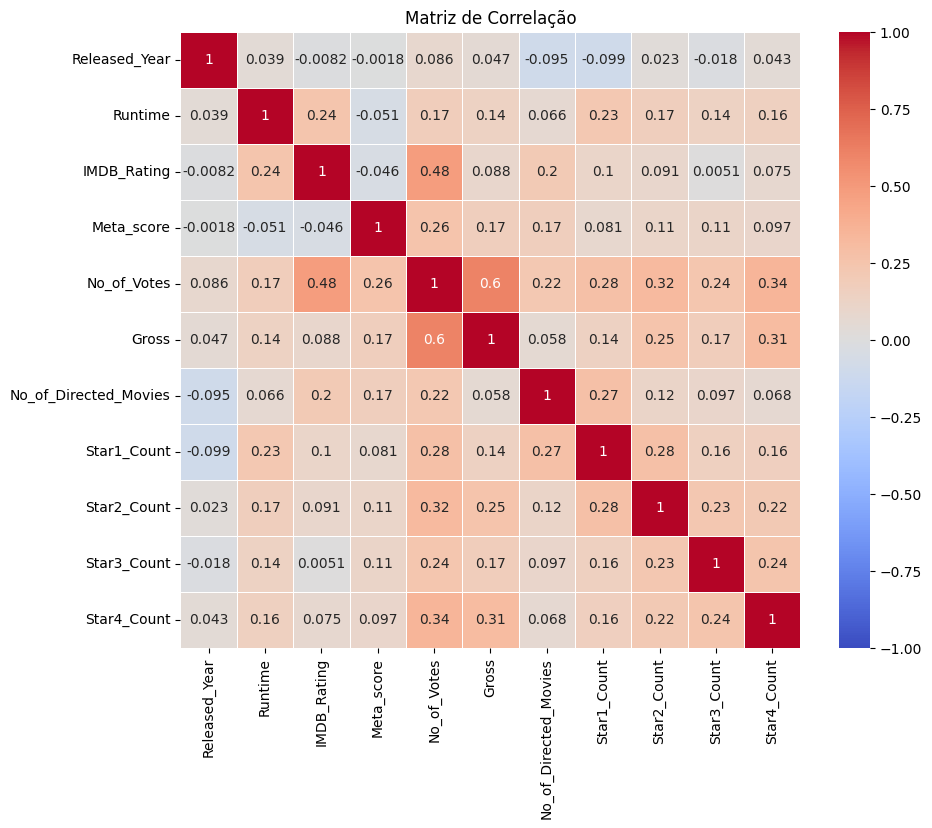

In [42]:
df_cleaned = df.dropna(subset=['Meta_score', 'Gross'])
df_numeric = df_cleaned.select_dtypes(include='number')

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

No momento, temos 3 variáveis numéricas de interesse. Meta_score e Gross, pois precisam ser preenchidos, e IMDB_Rating, pois o objetivo da entrega 3 é prevê-lo.

Da matriz acima, podemos tirar as seguintes conclusões:

1 - Meta_score possui uma correlação **POSITIVA MODERADA** com IMDB_Rating e uma **NEGATIVA MODERADA** com Released_Year, o que mostra que filmes bem recebidos pelo público tendem a ser bem recebidos pela crítica e comprova a teoria de que filmes mais antigos são melhor avaliados.

2 - Gross possui uma correlação **POSITIVA FORTE** com o No_of_Votes e **POSITIVA FRACA** com Released_Year, Runtime e IMDB_Rating, o que indica que filmes mais recentes e mais longos arrecadam mais dinheiro e costumam receber consideravelmente mais votos. Numa análise mais profunda, esses fatores sugerem que o cinema como um todo tem se tornado mais popular e mais lucrativo com o tempo.

3 - IMDB_Rating tem uma relação **NEGATIVA FRACA** com Released_Year, **POSITIVA FRACA** com Runtime e Gross, **POSITIVA MODERADA** com Meta_score e **POSITIVA FORTE** com No_of_Votes, o que sugere que o público tem preferência por filmes mais antigos e mais longos, e que filmes com boa aceitação do público tendem a ser melhor aceitos pela crítica, receber mais votos e faturar mais. 